In [1]:
import pandas as pd


# 2. 파일 경로 설정 (구글 드라이브 내 실제 파일 경로로 수정해주세요)
# 예: '/content/drive/MyDrive/폴더명/파일명.csv'
path1 = 'GENERAL_merged_result_columns_select_102cols.csv'
path2 = 'general_final_churn_score_result_240636_9.csv'

# 3. 데이터 불러오기 (인코딩 처리 포함)
def load_csv(path):
    try:
        return pd.read_csv(path, encoding='utf-8-sig')
    except:
        return pd.read_csv(path, encoding='cp949')

df_usage = load_csv(path1)
df_balance = load_csv(path2)

# 4. 데이터 병합 (Merge)
# '발급회원번호'를 기준으로 옆으로(how='inner') 합칩니다.
# 만약 한 회원의 데이터가 여러 달(기준년월)로 나뉘어 있다면,
# on=['발급회원번호', '기준년월'] 처럼 두 개를 모두 써야 중복 데이터가 생기지 않습니다.
df= pd.merge(df_usage, df_balance, on=['발급회원번호', '기준년월'], how='inner')

# 5. 결과 확인
print(f"첫 번째 파일 크기: {df_usage.shape}")
print(f"두 번째 파일 크기: {df_balance.shape}")
print(f"병합 후 파일 크기: {df.shape}")
df.head()

첫 번째 파일 크기: (240636, 102)
두 번째 파일 크기: (240636, 9)
병합 후 파일 크기: (240636, 109)


,기준년월,발급회원번호,증감율_이용건수_신용_전월,증감율_이용건수_체크_전월,증감율_이용금액_신용_전월,증감율_이용금액_신판_전월,증감율_이용금액_일시불_전월,증감율_이용금액_신용_분기,증감율_이용금액_일시불_분기,잔액_신판평균한도소진율_r6m,...,_1순위카드이용금액,최종유효년월_신용_이용,최종카드발급일자,Slope_Spend,Slope_Balance,Slope_Count,Risk_Flag,Churn_Score_Slope,Churn_Score_Total_Scaled,Final_Combined_Score
0,201807,SYN_1000048,0.020007,0.000000,0.249761,0.249761,0.249761,-0.420396,0.057435,0.223303,...,1572745,202205.0,20170918.0,0.0,0.0,0.0,0,0.0,5.749739,2.9
1,201808,SYN_1000048,-0.073442,0.000000,0.239299,0.239299,0.239299,-0.377131,0.024356,0.180827,...,1385707,202208.0,20170918.0,-87592.0,35188.0,-3.0,0,4.2,5.749733,5.0
2,201809,SYN_1000048,0.074553,0.000000,0.286712,0.286712,0.286712,0.121721,0.121721,0.147647,...,1544347,202302.0,20170918.0,-23516.0,-5000.0,-0.5,0,0.9,5.749733,3.3
3,201810,SYN_1000048,0.091676,-0.403293,0.328827,0.328827,0.328827,0.019740,0.019740,0.059904,...,1651927,202301.0,20170918.0,-2376.0,-99084.5,4.0,0,0.3,5.749747,3.0
4,201811,SYN_1000048,-0.128753,-0.585977,0.174194,0.174194,0.174194,0.624895,0.624895,0.052400,...,1652493,202208.0,20170918.0,-775.0,24316.5,3.5,0,0.0,5.749716,2.9


In [2]:
X = df[['Final_Combined_Score']].values

In [3]:
from sklearn.cluster import KMeans
# 클러스터 개수를 3개로 설정하고 모델 생성 (결과의 일관성을 위해 random_state 고정)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# 모델 학습 및 클러스터 예측 결과 추가
df['Cluster'] = kmeans.fit_predict(X)

# 각 클러스터에 몇 명의 고객이 배정되었는지 확인해볼까?
print(df['Cluster'].value_counts().sort_index())

Cluster
0     31844
1    206944
2      1848
Name: count, dtype: int64


Text(0, 0.5, 'Final Combined Score')

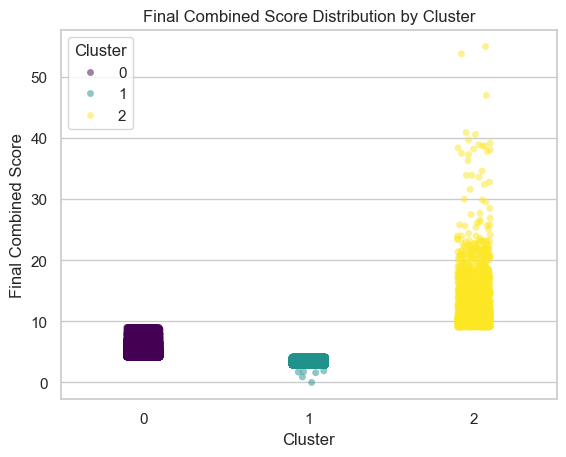

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")

# 클러스터별 점수 분포를 보기 위한 Strip Plot
sns.stripplot(x='Cluster', y='Final_Combined_Score', data=df, hue='Cluster', palette='viridis', jitter=True, alpha=0.5)

# 그래프 제목 및 라벨 설정
plt.title('Final Combined Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Final Combined Score')

In [5]:
# Cluster 정보를 바탕으로 Target 변수 생성
# 0: 유지(Cluster 0), 1: 이탈 위험(Cluster 1, 2)
df['Target'] = df['Cluster'].map({0: 0, 1: 1, 2: 1})

# 잘 바뀌었는지 상위 데이터만 살짝 확인해볼까?
print(df[['Final_Combined_Score', 'Cluster', 'Target']].head())

   Final_Combined_Score  Cluster  Target
0                   2.9        1       1
1                   5.0        0       0
2                   3.3        1       1
3                   3.0        1       1
4                   2.9        1       1


In [6]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import accuracy_score

In [7]:
# ============================================================================
# 핵심 1: 불필요한 컬럼 정의
# ============================================================================
target_col = 'Target'  # 정답지
drop_cols = ['Slope_Spend','Slope_Balance','Slope_Count', '발급회원번호', '기준년월',
    'Risk_Flag','Churn_Score_Slope','Churn_Score_Total_Scaled','Final_Combined_Score','Cluster','Target'
    ]
#'이용금액_신용_B0M',  '이용건수_신용_B0M','잔액_B0M'
# ============================================================================
# 핵심 2: 월별로 데이터 쪼개기 (Time Split)
# ============================================================================
# 1) 학습 데이터 (7, 8, 9, 10월)
train_df = df[df['기준년월'].isin([201807, 201808, 201809, 201810])]

# 2) 검증 데이터 (11월) - 모델 채점용
valid_df = df[df['기준년월'] == 201811]

# 3) 실전 예측 데이터 (12월) - 정답(Target)이 없는 미래 데이터
predict_df = df[df['기준년월'] == 201812]

# ============================================================================
# 핵심 3: X(문제), y(정답) 나누기
# ============================================================================
X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

X_predict = predict_df.drop(columns=drop_cols)
predict_ids = predict_df['발급회원번호'] # 결과 매칭용 ID 킵

# 문자열 -> category 변환 (LightGBM 최적화)
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')
        X_predict[col] = X_predict[col].astype('category')

# ============================================================================
# 핵심 4: 모델 학습
# ============================================================================
model = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


# ============================================================================
# 핵심 5: 12월 고객에 대한 이탈 확률 예측 및 결과 저장
# ============================================================================
pred_prob = model.predict_proba(X_predict)[:, 1]

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

print(final_result.sort_values('이탈예측확률', ascending=False).head(10))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[749]	valid_0's binary_logloss: 0.236583
             발급회원번호    이탈예측확률
10421   SYN_1117172  0.999946
160133  SYN_2804774  0.999944
181829   SYN_349390  0.999943
36011   SYN_1405600  0.999940
10961   SYN_1122137  0.999937
55601   SYN_1631497  0.999932
18779   SYN_1210119  0.999931
238739   SYN_980539  0.999929
108119  SYN_2230412  0.999928
105257  SYN_2197452  0.999928


In [8]:
pred_valid = model.predict(X_valid)
print("검증(11월) 정확도:", accuracy_score(y_valid, pred_valid))

검증(11월) 정확도: 0.9027576921158929


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# 검증 데이터에 대한 예측값
y_pred = model.predict(X_valid)

# 상세 리포트 출력
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.34      0.46      4829
           1       0.92      0.98      0.95     35277

    accuracy                           0.90     40106
   macro avg       0.81      0.66      0.70     40106
weighted avg       0.89      0.90      0.89     40106



In [10]:
# 1. 학습에 사용할 피처(X)와 정답(y) 분리
# ID성 컬럼과 점수/타겟 관련 컬럼은 제외합니다.
exclude_cols = ['발급회원번호', '기준년월', 'Target', 'Cluster', 'Final_Combined_Score',
                'Churn_Score_Slope', 'Churn_Score_Total_Scaled']

X = df.drop(columns=exclude_cols, errors='ignore')
y = df['Target']

print(f"원본 데이터 분포:\n{y.value_counts()}")

원본 데이터 분포:
Target
1    208792
0     31844
Name: count, dtype: int64


In [14]:
# !pip3 install imblearn

In [15]:
from imblearn.under_sampling import RandomUnderSampler

# 언더샘플링 적용
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f"언더샘플링 후 데이터 분포:\n{y_resampled.value_counts()}")

언더샘플링 후 데이터 분포:
Target
0    31844
1    31844
Name: count, dtype: int64


In [16]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import lightgbm as lgb

# 1. 기존 코드의 핵심 3번: X, y 나누기까지 진행
X_train_raw = train_df.drop(columns=drop_cols)
y_train_raw = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

# 2. [추가] 언더샘플링 적용 (학습 데이터에만!)
# 샘플링 전략을 'auto'로 하면 소수 클래스인 1에 맞춰 0의 개수를 줄입니다.
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_raw, y_train_raw)

print(f"샘플링 전 학습 데이터 (0, 1): {y_train_raw.value_counts().to_dict()}")
print(f"샘플링 후 학습 데이터 (0, 1): {y_train_rus.value_counts().to_dict()}")

# 3. 모델 학습 (핵심 4번)
# 샘플링된 X_train_rus, y_train_rus를 넣어서 학습시킵니다.
model = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

model.fit(
    X_train_rus, y_train_rus,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 4. 성능 확인 (Recall 점수 체크)
y_valid_pred = model.predict(X_valid)
print("\n--- 언더샘플링 적용 후 11월 검증 결과 ---")
print(classification_report(y_valid, y_valid_pred))

샘플링 전 학습 데이터 (0, 1): {1: 138064, 0: 22360}
샘플링 후 학습 데이터 (0, 1): {0: 22360, 1: 22360}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[287]	valid_0's binary_logloss: 0.408713

--- 언더샘플링 적용 후 11월 검증 결과 ---
              precision    recall  f1-score   support

           0       0.34      0.82      0.48      4829
           1       0.97      0.78      0.87     35277

    accuracy                           0.79     40106
   macro avg       0.65      0.80      0.67     40106
weighted avg       0.89      0.79      0.82     40106

